In [4]:
import numpy as np
from unidip.dip import diptst
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
from sklearn.cluster import KMeans

In [2]:
import tensorflow as tf
import keras
import keras.backend as K
from keras import layers, regularizers
from numba import cuda

In [1]:
class Autoencoder:
    def __init__(self, d,  m=5):
        self.encoder_input = keras.Input(shape=(d,))
        self.encoder_hidden = layers.Dense(500, activation='relu')(self.encoder_input)
        self.encoder_hidden = layers.Dense(500, activation='relu')(self.encoder_hidden)
        self.encoder_hidden = layers.Dense(2000, activation='relu')(self.encoder_hidden)
        self.encoder_output = layers.Dense(m, activation='relu')(self.encoder_hidden)
        self.encoder = keras.Model(self.encoder_input, self.encoder_output, name="encoder")

        self.decoder_input = keras.Input(shape=(m,))
        self.decoder_hidden = layers.Dense(2000, activation='relu')(self.decoder_input)
        self.decoder_hidden = layers.Dense(500, activation='relu')(self.decoder_hidden)
        self.decoder_hidden = layers.Dense(500, activation='relu')(self.decoder_hidden)
        self.decoder_output = layers.Dense(d, activation='sigmoid')(self.decoder_hidden)
        self.decoder = keras.Model(self.decoder_input, self.decoder_output, name="decoder")

        self.autoencoder_input = keras.Input(shape=(d,))
        self.autoencoder_output = self.decoder(self.encoder(self.autoencoder_input))
        self.autoencoder = keras.Model(self.autoencoder_input,self.autoencoder_output, name="autoencoder")
        
    def fit(self, data, loss, epochs=100, batch_size=256, learning_rate=0.001):
        opt = keras.optimizers.adam_v2.Adam(learning_rate=learning_rate)
        self.autoencoder.compile(optimizer=opt, loss=loss)
        self.autoencoder.fit(data, data,
                             epochs=epochs,
                             batch_size=batch_size,
                             shuffle=True,)
        
    def encode(self, data):
        return self.encoder(data)
    
    def decode(self, data):
        return self.decoder(data)

In [3]:
class DipDECK:
    def __init__(self, data, k_init=35, P_threshold=0.9, N_EPOCHS=100, N_BATCHSIZE=256):
        self.P_threshold = P_threshold
        self.batch_size = N_BATCHSIZE
        self.data = data
        self.N_DATA, self.N_FEATURE = data.shape
        self.k = k_init
        print('******************** pre-training AE ********************')
        self.AE = Autoencoder(self.N_FEATURE)
        self.AE.fit(data, self.L_rec, epochs=N_EPOCHS, batch_size=N_BATCHSIZE, learning_rate=0.001)
        print('******************** apply Kmeans ********************')
        self.Km_model = KMeans(self.k)
        self.Km_model.fit(self.AE.encode(data))
        self.kmCentres, self.labels = self.Km_model.cluster_centers_, self.Km_model.labels_
        print('********** finding closest points to kmCentres **********')
        self.centres = self.find_centres1()
        # print('******************** building DipMatrix ********************')
        self.DipMatrix = self.build_DipMatrix()
#         print(self.DipMatrix)
        print('******************** Batch optimizing ********************')
        self.Batch_optimize()
        
    def Batch_optimize(self, epochs=50, batch_size=256):
        i = 0
        while i<epochs:
            print(f'********** epoch {i+1} of {epochs} **********')
            random_perm = np.random.permutation(self.N_DATA)
            mini_batch_index = 0
            while True:
                self.indices = random_perm[mini_batch_index:mini_batch_index + batch_size]
                if i!=0:
                    self.update_labels(self.indices)
                self.AE.fit(self.data[self.indices], self.L, epochs=1, batch_size=batch_size, learning_rate=0.0001)
                print(f'Lrec: {self.L_rec(self.data[self.indices])}')
                print(f'Lclu: {self.L_clu(self.data[self.indices])}')
                print(f'L: {self.L(self.data[self.indices])}')
#                 print(self.AE.encode(self.centres))
                mini_batch_index += batch_size
                if mini_batch_index >= self.N_DATA:
                    break
            self.update_labels(range(self.k))
            self.centres = self.find_centres2()
            self.DipMatrix = self.build_DipMatrix()
#             print(self.DipMatrix)
            while np.max(self.DipMatrix-np.identity(self.k))>=self.P_threshold:
                self.k -= 1
                print(f'********** merging (remain {self.k}) **********')
                argmax = np.argmax(self.DipMatrix-np.identity(self.k+1))
                Ci, Cj = argmax//self.DipMatrix.shape[1], argmax%self.DipMatrix.shape[1]
                Ci, Cj = (Ci, Cj) if Ci<=Cj else (Cj, Ci)
                self.labels[self.labels==Cj] = Ci
                self.labels[self.labels>Cj] = self.labels[self.labels>Cj]-1
                new_centre = self.find_merged_centre(Ci, Cj)
                self.centres[Ci] = new_centre
                self.centres = np.delete(self.centres, Cj, 0)
                self.DipMatrix = self.update_DipMatrix(Ci, Cj)
#                 print(self.DipMatrix)
                i = 0
            i += 1
        
    def L_rec(self, y, y_pred=None):
#         return keras.losses.mean_squared_error(y, y_pred)
        return K.mean(K.sum(K.square(y - self.AE.decode(self.AE.encode(y))), axis=1))
    
    def L_clu(self, y, y_pred=None):
        specific_PMetrix = self.create_specific_PMetrix()
        encoded_centres = self.AE.encode(self.centres)
        r = K.sum(K.square(encoded_centres), axis=1)
        Dc = K.sqrt(K.transpose(r+tf.matmul(encoded_centres, K.transpose(encoded_centres)))+r)
        mean = K.sum(Dc)/(self.k**2-self.k)
        std = K.sqrt(K.sum(K.square(Dc-mean))/(self.k**2-self.k))
        return ((1+std)/mean)*K.mean(K.sum(specific_PMetrix*tf.transpose(K.sum(K.square(self.AE.encode(y)-tf.expand_dims(encoded_centres,1)), axis=-1)), axis=-1))
#         return K.mean(K.sum(specific_PMetrix*tf.transpose(K.sum(K.square(self.AE.encode(y)-tf.expand_dims(encoded_centres,1)), axis=-1)), axis=-1))
    
    def L(self, y, y_pred=None):
        return self.L_rec(y, y_pred) + self.L_clu(y, y_pred)
        
#     def Dist_centres(self):
#         encoded_centres = self.AE.encode(self.centres)
#         r = tf.reduce_sum(encoded_centres*encoded_centres, 1)
        
#         r = tf.reshape(r, [-1, 1])
#         D = tf.sqrt(r - 2*tf.matmul(encoded_centres, tf.transpose(encoded_centres)) + tf.transpose(r))
#         return D
    
    def create_specific_PMetrix(self):
        DipMatrix = self.Matrix2affine(self.DipMatrix)
        metrix = np.zeros((len(self.indices), DipMatrix.shape[1]), np.float32)
        i = 0
        for idx in self.indices:
            metrix[i] = DipMatrix[self.labels[idx]]
            i += 1
        return metrix
    
    def find_centres1(self):
        centres = []
        for kmCentre in self.kmCentres:
            dist = K.sum(K.square(self.AE.encode(self.data)-kmCentre), axis=1)
            centres.append(self.data[K.argmin(dist)])
        return np.array(centres)
    
    def find_centres2(self):
        encoded_data = self.AE.encode(self.data)
        centres = []
        for i in range(self.k):
            centre_ = K.mean(encoded_data[self.labels==i], axis=0)
            dist = K.sum(K.square(encoded_data-centre_), axis=1)
            centres.append(self.data[K.argmin(dist)])
        return np.array(centres)
    
    def find_merged_centre(self, Ci, Cj):
        data_CiCj = self.data[np.logical_or(self.labels==Ci,self.labels==Cj)]
        encoded_data_CiCj = self.AE.encode(data_CiCj)
        encoded_centres = self.AE.encode(self.centres)
        centre_Ci, centre_Cj = encoded_centres[Ci], encoded_centres[Cj]
        N_Ci, N_Cj = np.sum(self.labels==Ci), np.sum(self.labels==Cj)
        weighted_centre = (N_Ci*centre_Ci+N_Cj*centre_Cj)/(N_Ci+N_Cj)
        print(encoded_data_CiCj.shape, weighted_centre.shape)
        dist = np.sum(np.square(encoded_data_CiCj-weighted_centre), axis=-1)
        return data_CiCj[np.argmin(dist)]
    
    def build_DipMatrix(self):
        print(f'******************** building DipMatrix ********************')
        dip_matrix = np.identity(self.k)
        encoded_data = self.AE.encode(self.data)
        encoded_centres = self.AE.encode(self.centres)
        with tqdm(total=self.k*(self.k-1)//2) as pbar:
            for i in range(self.k):
                for j in range(i+1,self.k):
                    points = encoded_data[np.logical_or(self.labels==i,self.labels==j)]
                    C_1d = np.sum(points*(encoded_centres[i]-encoded_centres[j]), axis=-1)
                    dip_matrix[i,j] = dip_matrix[j,i] = diptst(C_1d)[1] if C_1d.size>=5 else 0
                    N_Ci, N_Cj = np.sum(self.labels==i), np.sum(self.labels==j)
                    (Ci, Cj, N_Ci, N_Cj) = (i, j, N_Ci, N_Cj) if N_Ci<=N_Cj else (j, i, N_Cj, N_Ci)
                    if N_Cj>2*N_Ci:
                        points_Cj = encoded_data[self.labels==Cj]
                        dist2Ci = np.sum(np.square(points_Cj-encoded_centres[Ci]), axis=-1)
                        partition_points_Cj = points_Cj[dist2Ci<=np.partition(dist2Ci,2*N_Ci)[2*N_Ci-1]]
                        points = np.concatenate([encoded_data[self.labels==Ci], partition_points_Cj])
                        C_1d = np.sum(points*(encoded_centres[i]-encoded_centres[j]), axis=-1)
                        p_value = diptst(C_1d)[1]
                        p_value = p_value if p_value else 0
                        dip_matrix[i,j] = dip_matrix[j,i] = min(dip_matrix[i,j], p_value)
                    pbar.update(1)
        return dip_matrix
    
    def update_DipMatrix(self, idx, jdx):
        print(f'******************** updating DipMatrix ********************')
        dip_matrix = np.delete(np.delete(self.DipMatrix, jdx, axis=0), jdx, axis=1)
        encoded_data = self.AE.encode(self.data)
        encoded_centres = self.AE.encode(self.centres)
        with tqdm(total=self.k-1) as pbar:
            for j in range(self.k):
                if j==idx:
                    continue
                points = encoded_data[np.logical_or(self.labels==idx,self.labels==j)]
                C_1d = np.sum(points*(encoded_centres[idx]-encoded_centres[j]), axis=-1)
                dip_matrix[idx,j] = dip_matrix[j,idx] = diptst(C_1d)[1] if C_1d.size>=5 else 0
                N_Ci, N_Cj = np.sum(self.labels==idx), np.sum(self.labels==j)
                (Ci, Cj, N_Ci, N_Cj) = (idx, j, N_Ci, N_Cj) if N_Ci<=N_Cj else (j, idx, N_Cj, N_Ci)
                if N_Cj>2*N_Ci:
                    points_Cj = encoded_data[self.labels==Cj]
                    dist2Ci = np.sum(np.square(points_Cj-encoded_centres[Ci]), axis=-1)
                    partition_points_Cj = points_Cj[dist2Ci<=np.partition(dist2Ci,2*N_Ci)[2*N_Ci-1]]
                    points = np.concatenate([encoded_data[self.labels==Ci], partition_points_Cj])
                    C_1d = np.sum(points*(encoded_centres[idx]-encoded_centres[j]), axis=-1)
                    p_value = diptst(C_1d)[1]
                    p_value = p_value if p_value else 0
                    dip_matrix[idx,j] = dip_matrix[j,idx] = min(dip_matrix[idx,j], p_value)
                pbar.update(1)
        return dip_matrix
        
    def Matrix2affine(self, matrix):
        return (matrix.T/matrix.sum(axis=1)).T
    
    def update_labels(self, indices):
        encoded_data = self.AE.encode(self.data)
        encoded_centres = tf.expand_dims(self.AE.encode(self.centres),1)
        D = np.sum(np.square(encoded_data-encoded_centres), axis=-1)
        new_labels = np.argmin(D, axis=0)
        self.labels[indices] = new_labels[indices]

In [9]:
A = np.random.randint(1,100, (4,5))
A

array([[76, 96, 70, 35, 35],
       [61,  5, 71,  4, 65],
       [45, 18,  9, 82, 59],
       [ 7, 44, 49, 66, 55]])

In [10]:
np.delete(np.delete(A, 1, axis=0),1,axis=1)

array([[76, 70, 35, 35],
       [45,  9, 82, 59],
       [ 7, 49, 66, 55]])

# Test

In [11]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype(np.float32)/255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_train = x_train[:3000]

x_test = x_test.astype(np.float32)/255
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(3000, 784)
(10000, 784)


In [4]:
Model = DipDECK(x_train, k_init=15, N_EPOCHS=100)

NameError: name 'x_train' is not defined

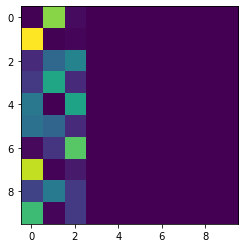

In [23]:
plt.imshow(tf.math.confusion_matrix(y_train[:3000], Model.labels))

In [18]:
from ipywidgets import interact
import ipywidgets as widgets

encoded_img = Model.AE.encoder.predict(x_test)
decoded_img = Model.AE.decoder.predict(encoded_img)

def f(i):
    fig = plt.Figure(figsize=(10,10))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    ax1.axis('off')
    # ax2.axis('off')
    ax3.axis('off')
    ax1.imshow(x_test[i].reshape(28,28), cmap='gray')
    ax2.imshow(encoded_img[i].reshape(1,5), cmap='gray')
    ax3.imshow(decoded_img[i].reshape(28,28), cmap='gray')
    return fig
    
interact(f, i=widgets.IntSlider(min=0, max=9999, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=9999), Output()), _dom_classes=('widget-interact…

<function __main__.f(i)>

In [17]:
encoded_img = Model.AE.encoder.predict(Model.centres)
decoded_img = Model.AE.decoder.predict(encoded_img)

def g(i):
    fig = plt.Figure(figsize=(10,10))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    ax1.axis('off')
    # ax2.axis('off')
    ax3.axis('off')
    ax1.imshow(x_test[i].reshape(28,28), cmap='gray')
    ax2.imshow(encoded_img[i].reshape(1,5), cmap='gray')
    ax3.imshow(decoded_img[i].reshape(28,28), cmap='gray')
    return fig
    
interact(g, i=widgets.IntSlider(min=0, max=Model.k-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='i', max=2), Output()), _dom_classes=('widget-interact',)…

<function __main__.g(i)>